# RNN and LSTM with PyTorch

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

## RNN  
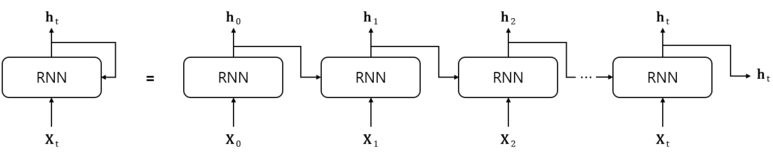

### Word Processing

In [6]:
sentences = ["i like dog", "i love coffee", "i hate milk", "you like cat", "you love milk", "you hate coffee"]
dtype = torch.float

word_list = list(set(" ".join(sentences).split()))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)

print(word_dict)
print(number_dict)

{'dog': 0, 'you': 1, 'like': 2, 'i': 3, 'cat': 4, 'hate': 5, 'coffee': 6, 'milk': 7, 'love': 8}
{0: 'dog', 1: 'you', 2: 'like', 3: 'i', 4: 'cat', 5: 'hate', 6: 'coffee', 7: 'milk', 8: 'love'}


### TextRNN Parameter

In [3]:
batch_size = len(sentences)
n_step = 2  # 학습 하려고 하는 문장의 길이 - 1
n_hidden = 5  # 은닉층 사이즈

def make_batch(sentences):
    input_batch = []
    target_batch = []

    for sen in sentences:
        word = sen.split() # ["i", "like", "dog"]
        input = [word_dict[n] for n in word[:-1]] # [0, 7]
        target = word_dict[word[-1]] # [1]

        input_batch.append(np.eye(n_class)[input])  # One-Hot Encoding
        target_batch.append(target) # [1, 2, 3, 8, 3, 2]
  
    return input_batch, target_batch

input_batch, target_batch = make_batch(sentences)

input_batch = torch.tensor(input_batch, dtype=torch.float32, requires_grad=True)
target_batch = torch.tensor(target_batch, dtype=torch.int64)

C:\Users\mark\AppData\Local\Temp\ipykernel_5576\1646624732.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  input_batch = torch.tensor(input_batch, dtype=torch.float32, requires_grad=True)


### TextRNN

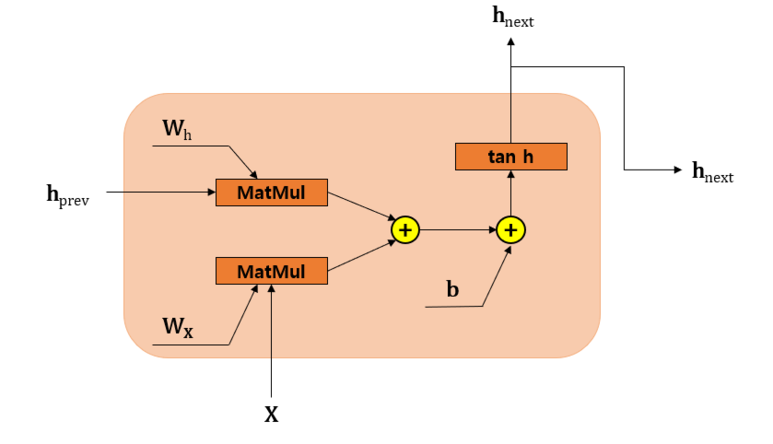

In [7]:
class TextRNN(nn.Module):
    def __init__(self):
        super(TextRNN, self).__init__()
        self.rnn = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.3)
        self.W = nn.Parameter(torch.randn([n_hidden, n_class]).type(dtype))
        self.b = nn.Parameter(torch.randn([n_class]).type(dtype))
        self.Softmax = nn.Softmax(dim=1)

    def forward(self, hidden, X):
        X = X.transpose(0, 1)
        outputs, hidden = self.rnn(X, hidden)
        outputs = outputs[-1]  # 최종 예측 Hidden Layer
        model = torch.mm(outputs, self.W) + self.b  # 최종 예측 최종 출력 층
        return model

### Training  

num_layers * num_directions(단방향일시 1, 양방향일시 2), 해당 모델에서는 레이어의 갯수가 1인 단방향 모델이니 1 (zero)  
hidden <- zeros: 처음 상태에서는 그 전에 들어온 단어가 없기 때문에 아직 문맥이란게 존재 하지 않기 때문  

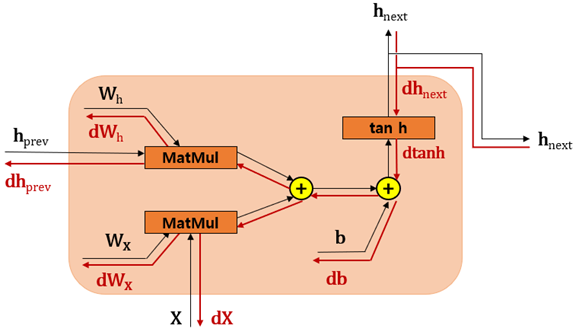

In [5]:
model = TextRNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(500):
    hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
    output = model(hidden, input_batch)
    loss = criterion(output, target_batch)

    if (epoch + 1) % 100 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

C:\Users\mark\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0100 cost = 0.481588
Epoch: 0200 cost = 0.095573
Epoch: 0300 cost = 0.035271
Epoch: 0400 cost = 0.019182
Epoch: 0500 cost = 0.012347
[['i', 'like'], ['i', 'love'], ['i', 'hate'], ['you', 'like'], ['you', 'love'], ['you', 'hate']] -> ['dog', 'coffee', 'milk', 'cat', 'milk', 'coffee']


### Result

In [ ]:
input = [sen.split()[:2] for sen in sentences]

hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
predict = model(hidden, input_batch).data.max(1, keepdim=True)[1]
print([sen.split()[:2] for sen in sentences], '->', [number_dict[n.item()] for n in predict.squeeze()])

## LSTM

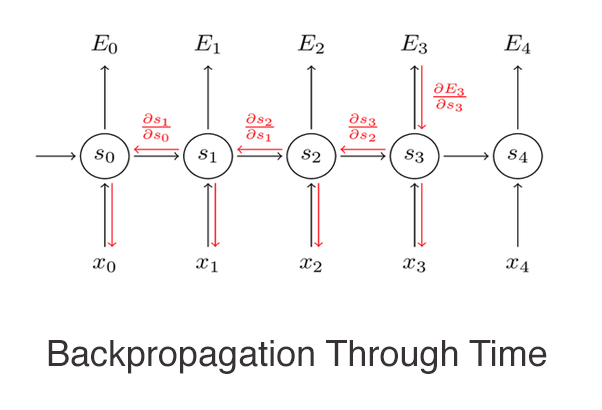  
  
왜 RNN은 이러한 장기 의존 관계에 대해서 약한 것일까? 이 점에 대해서는 RNN의 Backpropagation을 살펴보면 알 수 있다.  
그림과 같이 RNN에서의 Backpropagation은 RNN 계층이 과거 방향으로 시간을 거슬러 가면서 gradient를 전달하게 된다. 
  
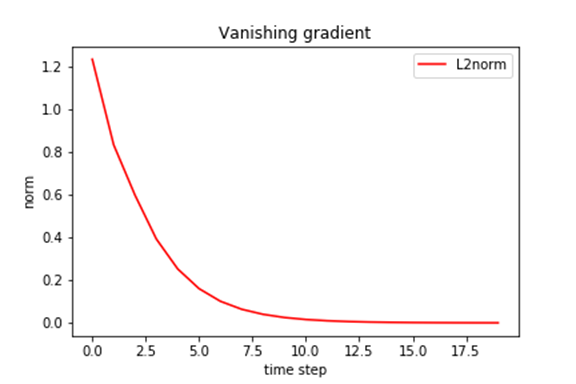  
   
하지만 이러한 기울기는 RNN 계층이 길어지게 되면 기울기가 작아지게 된다.  
이를 Vanishing Gradient Problem(기울기 소실)이라고 한다.  

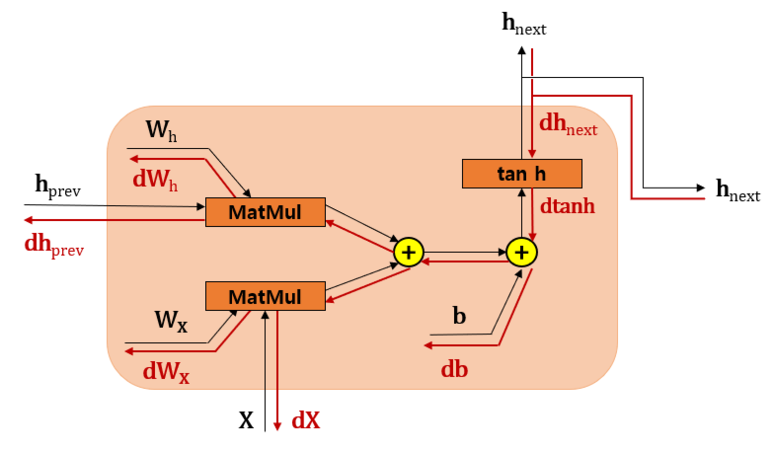  
  
위는 RNN 셀의 구조이다. 위의 구조 중 'tanh'에만 주목해보자.  
  
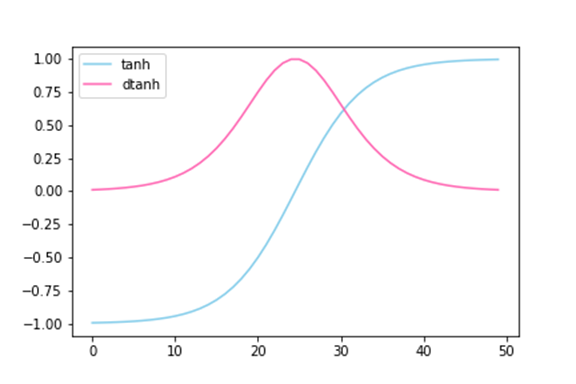  
  
 tanh와 dtanh의 그래프 모양은 위 그래프와 같다.  
여기서 우리는 gradient에 관심이 있으므로, dtanh에 주목해보면 dtanh 값은 항상 0~1 사이의 값인 것을 알 수 있다.  
이는 역전파에서 gradient가 tanh 노드를 지날 때마다 값이 계속 작아진다는 의미이다.  
tanh를 T번 통과하게 되면 gradient도 T번 반복해서 작아지게 된다.  
그렇기 때문에 RNN 계층이 길어지게 되면 Vanishing Gradient Problem이 발생하게 된다.  

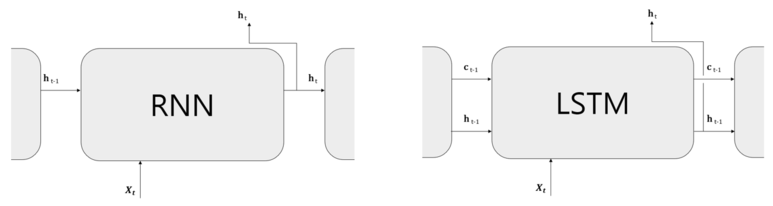  
  
위 그림은 RNN과 LSTM의 인터페이스를 비교한 그림이다.  
인터페이스만 보더라도 LSTM 계층에는 c라는 경로가 추가된 것을 알 수 있다.  
이 c를 기억 셀memory cell이라 하며, LSTM의 전용 기억 매커니즘이다.  
기억 셀의 특징은 데이터를 LSTM 계층 내에서만 주고 받고, 다른 계층으로는 출력하지 않는다는 것이다.  
즉, 이는 LSTM도 내부적으로만 다르지 사용하는 입장에서는 RNN과 같은 인터페이스를 갖는다.  

ct에는 시각 t에서의 LSTM의 메모리가 저장되어 있는데, 과거로부터 시각 t까지에 필요한 메모리가 저장되어 있다고 가정하자.  
그리고 필요한 정보를 모두 간직한 이 메모리를 바탕으로 외부 계층에 Hidden State ht를 출력한다.  
이때 출력하는 ht는 다음 그림과 같이 기억 셀의 값은 tanh 함수로 변환한 값이다.  
(여기서의 tanh는 각 요소에 tanh 함수를 적용한다는 뜻이다.)  
여기서 핵심은 3개의 입력 (xt, ht-1, ct-1)를 이용하여 구한 ct를 사용해 Hidden State ht를 계산한다는 것이다.  
  
__LSTM 구조의 핵심은 ht는 단기상태 (Short Term) ct는 장기 상태 (Long Term)라고 볼 수 있다.__  

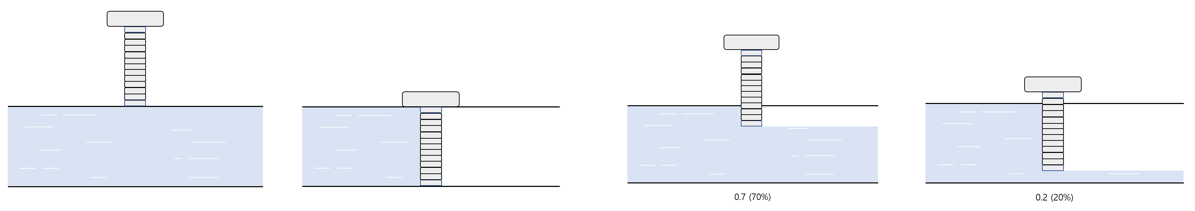  
  
다음 내용을 이해하기 위해 게이트의 개념에 대해 이해하고 넘어가자. 게이트는 데이터의 흐름을 제어한다.  
위의 그림처럼 물의 흐름을 제어하는 것이 게이트의 역할이다.  
LSTM에서의 게이트는 '열기/닫기' 뿐 아니라, 어느 정도 열지를 조절할 수 있다.  
  
그리고 이 열기 ~ 닫기 까지의 정도를 0.0 ~ 1.0의 실수로 표현할 수 있다.  
이 0.0 ~ 1.0의 값이 다음으로 넘어갈 데이터의 양을 결정한다.  
  
여기서 중요한 점은 '게이트를 얼마나 열지'라는 것도 데이터로부터 자동으로 학습된다는 점이다.  
  
그리고 여기서 0.0 ~ 1.0이라는 범위에 주목해보자.  
우리는 이러한 범위를 가지는 매우 좋은 함수를 알고있다.  
  
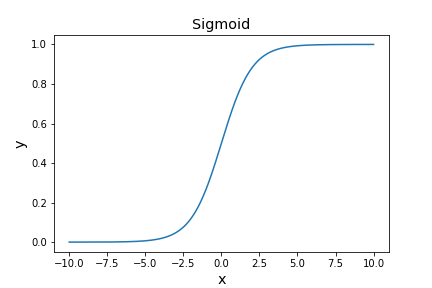  
  
바로 Sigmoid 함수이다. Sigmoid 함수를 이용하면 어떤 값을 넣더라도 0.0 ~ 1.0의 값을 가질 수 있다.  
그렇기 때문에 LSTM의 게이트에서는 tanh가 아닌 Sigmoid 함수를 사용한다.